In [1]:
import psycopg2 as psql
import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
from plotnine import *


In [2]:
try:
    conn = psql.connect("dbname=swhgd-popular-3k-python user=postgres password=postgres")
except psql.Error as e:
    print(type(e))
    print(e)

![](dataset-schema.png)

In [3]:
query = """SELECT DISTINCT ON (o.url) o.url as url, 
CASE WHEN '2017-11-01'::DATE <= rev.date AND rev.date <= '2018-01-01'::DATE THEN 1 ELSE 0 END AS status,
count(rev.author) AS author_count,
o.type AS host_type,
CASE WHEN count(rel.date) >= 1 THEN 1 ELSE 0 END AS major_releases
FROM revision rev 
FULL JOIN release rel on rev.id = rel.target
FULL JOIN snapshot_branch s_b ON rev.id = s_b.target 
FULL JOIN snapshot_branches s_bs ON s_bs.branch_id = s_b.object_id
FULL JOIN snapshot s ON s.object_id = s_bs.snapshot_id
FULL JOIN origin_visit ov ON ov.snapshot_id = s.object_id
FULL JOIN origin o on o.id = ov.origin
WHERE (rev.date >= '2005-01-01'::DATE AND rev.date <= '2018-01-01'::DATE)
GROUP BY o.url, rev.date, o.type;"""
data = sqlio.read_sql_query(query, conn)
data

,url,status,author_count,host_type,major_releases
0,deb://Debian/packages/accerciser,0,207,deb,0
1,deb://Debian/packages/agtl,0,621,deb,0
2,deb://Debian/packages/ajaxterm,0,624,deb,0
3,deb://Debian/packages/alacarte,0,207,deb,0
4,deb://Debian/packages/angrydd,0,209,deb,0
...,...,...,...,...,...
2081,https://pypi.org/project/zc.lockfile/,0,1,pypi,0
2082,https://pypi.org/project/zope.component/,0,1,pypi,0
2083,https://pypi.org/project/zope.deprecation/,0,1,pypi,0
2084,https://pypi.org/project/zope.interface/,0,1,pypi,0


In [4]:
query = """SELECT DISTINCT ON (o.url) o.url as url, min(r.date) OVER (PARTITION BY o.url) as min_date
FROM revision r join snapshot_branch s_b ON r.id = s_b.target 
FULL JOIN snapshot_branches s_bs ON s_bs.branch_id = s_b.object_id
FULL JOIN snapshot s ON s.object_id = s_bs.snapshot_id
FULL JOIN origin_visit ov ON ov.snapshot_id = s.object_id
FULL JOIN origin o on o.id = ov.origin
WHERE (r.date >= '2005-01-01'::DATE AND r.date <= '2018-01-01'::DATE);"""
min_dates = sqlio.read_sql_query(query, conn)
min_dates

,url,min_date
0,deb://Debian/packages/accerciser,2012-04-18 10:06:21-07:00
1,deb://Debian/packages/agtl,2011-01-22 04:55:12-08:00
2,deb://Debian/packages/ajaxterm,2011-08-19 07:31:06-07:00
3,deb://Debian/packages/alacarte,2012-06-29 03:43:50-07:00
4,deb://Debian/packages/angrydd,2008-10-19 05:19:40-07:00
...,...,...
2080,https://pypi.org/project/youtube_dl/,2013-01-19 16:34:50-08:00
2081,https://pypi.org/project/zc.lockfile/,2007-07-18 04:27:21-07:00
2082,https://pypi.org/project/zope.component/,2007-02-19 06:16:09-08:00
2083,https://pypi.org/project/zope.deprecation/,2007-02-18 13:55:54-08:00


In [5]:
query = """SELECT DISTINCT ON (o.url) o.url as url, max(r.date) OVER (PARTITION BY o.url) as max_date
FROM revision r join snapshot_branch s_b ON r.id = s_b.target 
FULL JOIN snapshot_branches s_bs ON s_bs.branch_id = s_b.object_id
FULL JOIN snapshot s ON s.object_id = s_bs.snapshot_id
FULL JOIN origin_visit ov ON ov.snapshot_id = s.object_id
FULL JOIN origin o on o.id = ov.origin
WHERE (r.date >= '2005-01-01'::DATE AND r.date <= '2018-01-01'::DATE);"""
max_dates = sqlio.read_sql_query(query, conn)
max_dates

,url,max_date
0,deb://Debian/packages/accerciser,2017-12-13 05:26:58-08:00
1,deb://Debian/packages/agtl,2015-08-19 13:36:54-07:00
2,deb://Debian/packages/ajaxterm,2015-05-31 10:43:09-07:00
3,deb://Debian/packages/alacarte,2017-12-18 18:44:02-08:00
4,deb://Debian/packages/angrydd,2016-04-24 12:35:20-07:00
...,...,...
2080,https://pypi.org/project/youtube_dl/,2017-12-30 13:32:44-08:00
2081,https://pypi.org/project/zc.lockfile/,2016-06-19 09:27:26-07:00
2082,https://pypi.org/project/zope.component/,2017-09-26 04:17:58-07:00
2083,https://pypi.org/project/zope.deprecation/,2017-08-07 12:24:01-07:00


In [6]:
durations = pd.merge(left=max_dates, right=min_dates, left_on='url', right_on='url')
durations['duration'] = (((durations['max_date'] - durations['min_date'])/np.timedelta64(1,'D'))/28).astype(int) #convert timedelta in days to int that represents months
durations = durations.drop(columns=['max_date', 'min_date'])
durations

,url,duration
0,deb://Debian/packages/accerciser,73
1,deb://Debian/packages/agtl,59
2,deb://Debian/packages/ajaxterm,49
3,deb://Debian/packages/alacarte,71
4,deb://Debian/packages/angrydd,98
...,...,...
2080,https://pypi.org/project/youtube_dl/,64
2081,https://pypi.org/project/zc.lockfile/,116
2082,https://pypi.org/project/zope.component/,138
2083,https://pypi.org/project/zope.deprecation/,136


In [7]:
data = data.merge(durations, on='url')

In [8]:
projects = []
for elem in data['url'].str.findall("(.+)/(.+)(/*$)"):
    projects.append(elem[0][1].replace("/",""))
data['project'] = projects
data


,url,status,author_count,host_type,major_releases,duration,project
0,deb://Debian/packages/accerciser,0,207,deb,0,73,accerciser
1,deb://Debian/packages/agtl,0,621,deb,0,59,agtl
2,deb://Debian/packages/ajaxterm,0,624,deb,0,49,ajaxterm
3,deb://Debian/packages/alacarte,0,207,deb,0,71,alacarte
4,deb://Debian/packages/angrydd,0,209,deb,0,98,angrydd
...,...,...,...,...,...,...,...
2080,https://pypi.org/project/youtube_dl/,0,1,pypi,0,64,youtube_dl
2081,https://pypi.org/project/zc.lockfile/,0,1,pypi,0,116,zc.lockfile
2082,https://pypi.org/project/zope.component/,0,1,pypi,0,138,zope.component
2083,https://pypi.org/project/zope.deprecation/,0,1,pypi,0,136,zope.deprecation


In [9]:
data['project'].value_counts()

s3cmd                3
supervisor           3
pylint               3
tqdm                 3
models               2
                    ..
python-wrapt         1
python-whoosh        1
python-whiteboard    1
python-werkzeug      1
zope.interface       1
Name: project, Length: 2020, dtype: int64

In [22]:
data['url'] = data['url'].astype(str)
data['host_type'] = data['host_type'].astype(str)
data['project'] = data['project'].astype(str)
data.to_csv('data.csv')


/Users/derekrobinson/miniconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


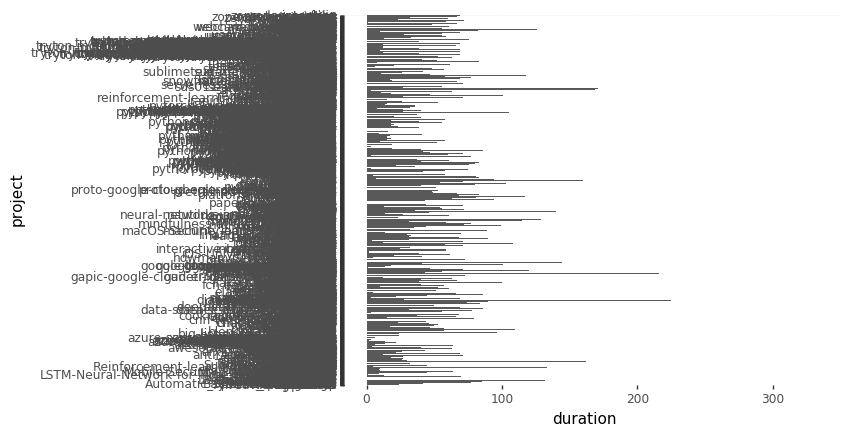

<ggplot: (8785617236581)>

In [26]:
dur_chart = (ggplot(data, aes(x='project', y='duration'))
+ geom_col()
+ coord_flip())
dur_chart

In [25]:
data.duration.max()

169